# Chapter 11 – Training Deep Neural Networks

This notebook contains all the sample code and solutions to the exercises in chapter 11.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/deep``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem

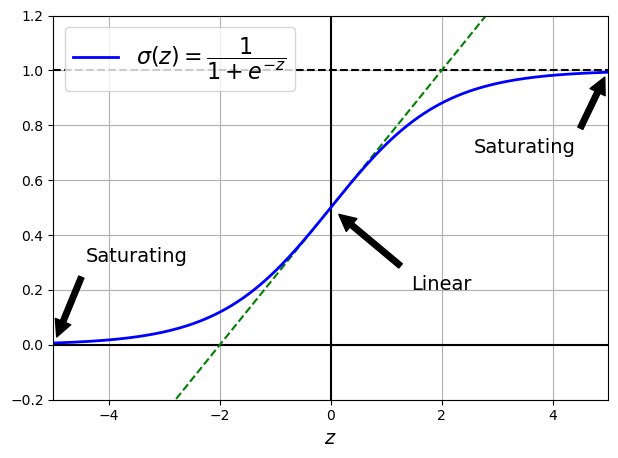

In [5]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions
### Leaky ReLU

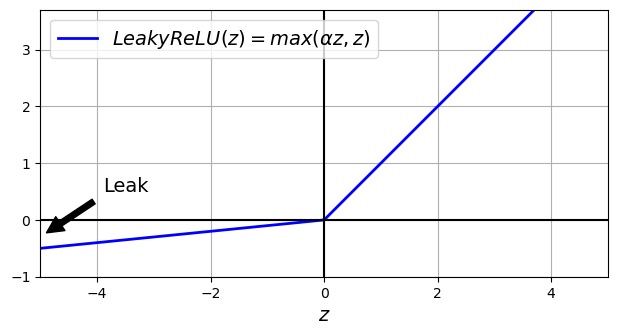

In [8]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()


In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU
Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [11]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU
By default, the SELU hyperparameters (```scale``` and ```alpha```) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

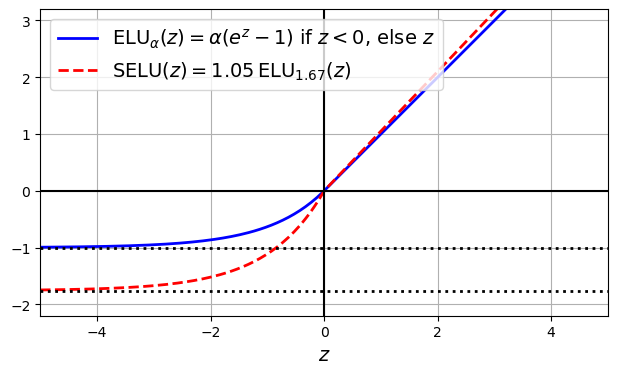

In [12]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [13]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

#scaling the data
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 12s 5ms/step - loss: 1.0968 - accuracy: 0.5815 - val_loss: 0.7197 - val_accuracy: 0.7374
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7127 - accuracy: 0.7471 - val_loss: 0.7117 - val_accuracy: 0.7714
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6043 - accuracy: 0.7915 - val_loss: 0.5381 - val_accuracy: 0.8120
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5178 - accuracy: 0.8220 - val_loss: 0.5002 - val_accuracy: 0.8288
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4788 - accuracy: 0.8350 - val_loss: 0.4771 - val_accuracy: 0.8288


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 5ms/step - loss: 1.9655 - accuracy: 0.2075 - val_loss: 1.6683 - val_accuracy: 0.2660
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 1.3811 - accuracy: 0.4015 - val_loss: 1.1976 - val_accuracy: 0.5032
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0651 - accuracy: 0.5617 - val_loss: 0.9476 - val_accuracy: 0.6090
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0119 - accuracy: 0.5814 - val_loss: 1.1591 - val_accuracy: 0.5544
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0791 - accuracy: 0.5533 - val_loss: 0.9279 - val_accuracy: 0.6382


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

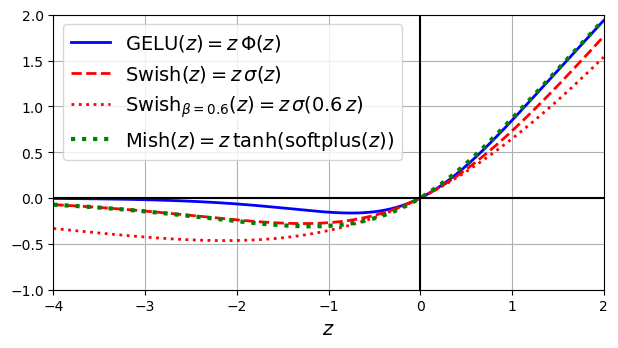

In [24]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

## Batch Normalization

In [25]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5451 - accuracy: 0.8097 - val_loss: 0.3850 - val_accuracy: 0.8606
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4006 - accuracy: 0.8568 - val_loss: 0.3497 - val_accuracy: 0.8674



Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a ```BatchNormalization``` layer does not need to have bias terms, since the ```BatchNormalization``` layer some as well, it would be a waste of parameters, so you can set ```use_bias=False``` when creating those layers:

In [30]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:

# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 933us/step - loss: 0.5894 - accuracy: 0.8028 - val_loss: 0.4275 - val_accuracy: 0.8484
Epoch 2/2
1719/1719 [==============================] - 2s 879us/step - loss: 0.4218 - accuracy: 0.8520 - val_loss: 0.3717 - val_accuracy: 0.8656


## Gradient Clipping

All ```tf.keras.optimizers``` accept ```clipnorm``` or ```clipvalue``` arguments:

In [33]:

optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [34]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers
### Reusing a Keras model

Let's split the fashion MNIST training set in two:

* ```X_train_A```: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* ```X_train_B```: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [35]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 [==============================] - 1s 767us/step - loss: 1.1425 - accuracy: 0.6397 - val_loss: 0.6990 - val_accuracy: 0.7676
Epoch 2/20
1376/1376 [==============================] - 1s 711us/step - loss: 0.6095 - accuracy: 0.8010 - val_loss: 0.5217 - val_accuracy: 0.8258
Epoch 3/20
1376/1376 [==============================] - 1s 714us/step - loss: 0.4928 - accuracy: 0.8418 - val_loss: 0.4488 - val_accuracy: 0.8518
Epoch 4/20
1376/1376 [==============================] - 1s 711us/step - loss: 0.4335 - accuracy: 0.8602 - val_loss: 0.4047 - val_accuracy: 0.8664
Epoch 5/20
1376/1376 [==============================] - 1s 715us/step - loss: 0.3963 - accuracy: 0.8705 - val_loss: 0.3769 - val_accuracy: 0.8716
Epoch 6/20
1376/1376 [==============================] - 1s 723us/step - loss: 0.3700 - accuracy: 0.8770 - val_loss: 0.3569 - val_accuracy: 0.8759
Epoch 7/20
1376/1376 [==============================] - 1s 720us/step - loss: 0.3509 - accuracy: 0.8824 - val_loss: 0.3411 -

In [36]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6848 - accuracy: 0.5150 - val_loss: 0.6782 - val_accuracy: 0.5776
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.6050 - val_loss: 0.6592 - val_accuracy: 0.6459
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6421 - accuracy: 0.6650 - val_loss: 0.6427 - val_accuracy: 0.6756
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6200 - accuracy: 0.7250 - val_loss: 0.6256 - val_accuracy: 0.7003
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6025 - accuracy: 0.7500 - val_loss: 0.6069 - val_accuracy: 0.7527
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5840 - accuracy: 0.7950 - val_loss: 0.5889 - val_accuracy: 0.7972
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5658 - accuracy: 0.8450 - val_loss: 0.5715 - val_accuracy: 0.8299
Epoch 8/20
7/7 [=================

[0.42434459924697876, 0.9075000286102295]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [37]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that ```model_B_on_A``` and ```model_A``` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build ```model_B_on_A``` on top of a clone of ```model_A```:

In [38]:

tf.random.set_seed(42)  # extra code – ensure reproducibility

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [40]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 16ms/step - loss: 1.9753 - accuracy: 0.5550 - val_loss: 1.5362 - val_accuracy: 0.5153
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 1.1639 - accuracy: 0.5550 - val_loss: 0.9195 - val_accuracy: 0.5242
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.7569 - accuracy: 0.5900 - val_loss: 0.7264 - val_accuracy: 0.5717
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.6550 - val_loss: 0.6648 - val_accuracy: 0.6390
Epoch 1/16
7/7 [==============================] - 0s 16ms/step - loss: 0.6029 - accuracy: 0.7150 - val_loss: 0.5876 - val_accuracy: 0.6993
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.5567 - accuracy: 0.7550 - val_loss: 0.5467 - val_accuracy: 0.7626
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.5182 - accuracy: 0.8000 - val_loss: 0.5250 - val_accuracy: 0.8022
Epoch 4/16
7/7 [====================

So, what's the final verdict?

In [43]:

model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 516us/step - loss: 0.3283 - accuracy: 0.9105


[0.32826152443885803, 0.9104999899864197]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%: (closer to 11% for me)

In [44]:
1 - (100 - 92.75) / (100 - 91.85)

0.11042944785276132

## Faster Optimizers

In [45]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 1s 762us/step - loss: 0.6846 - accuracy: 0.7656 - val_loss: 0.5152 - val_accuracy: 0.8096
Epoch 2/10
1719/1719 [==============================] - 1s 712us/step - loss: 0.4650 - accuracy: 0.8361 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 3/10
1719/1719 [==============================] - 1s 713us/step - loss: 0.4182 - accuracy: 0.8525 - val_loss: 0.4083 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 1s 715us/step - loss: 0.3908 - accuracy: 0.8621 - val_loss: 0.3775 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 1s 714us/step - loss: 0.3691 - accuracy: 0.8685 - val_loss: 0.3669 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 1s 710us/step - loss: 0.3555 - accuracy: 0.8729 - val_loss: 0.3654 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 1s 710us/step - loss: 0.3404 - accuracy: 0.8782 - val_loss: 0.3576 -

### Momentum optimization

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 1s 766us/step - loss: 0.6974 - accuracy: 0.7621 - val_loss: 0.4996 - val_accuracy: 0.8222
Epoch 2/10
1719/1719 [==============================] - 1s 716us/step - loss: 0.4670 - accuracy: 0.8359 - val_loss: 0.4429 - val_accuracy: 0.8418
Epoch 3/10
1719/1719 [==============================] - 1s 716us/step - loss: 0.4226 - accuracy: 0.8510 - val_loss: 0.4018 - val_accuracy: 0.8578
Epoch 4/10
1719/1719 [==============================] - 1s 716us/step - loss: 0.3952 - accuracy: 0.8628 - val_loss: 0.3830 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 1s 716us/step - loss: 0.3739 - accuracy: 0.8682 - val_loss: 0.3726 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 1s 717us/step - loss: 0.3606 - accuracy: 0.8718 - val_loss: 0.3733 - val_accuracy: 0.8648
Epoch 7/10
1719/1719 [==============================] - 1s 717us/step - loss: 0.3442 - accuracy: 0.8763 - val_loss: 0.3641 -

### Nesterov Accelerated Gradient

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [51]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 776us/step - loss: 0.6837 - accuracy: 0.7667 - val_loss: 0.5008 - val_accuracy: 0.8222
Epoch 2/10
1719/1719 [==============================] - 1s 725us/step - loss: 0.4615 - accuracy: 0.8383 - val_loss: 0.4369 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 1s 724us/step - loss: 0.4172 - accuracy: 0.8516 - val_loss: 0.3993 - val_accuracy: 0.8582
Epoch 4/10
1719/1719 [==============================] - 1s 727us/step - loss: 0.3911 - accuracy: 0.8626 - val_loss: 0.3845 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 1s 726us/step - loss: 0.3710 - accuracy: 0.8679 - val_loss: 0.3749 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 1s 725us/step - loss: 0.3562 - accuracy: 0.8723 - val_loss: 0.3711 - val_accuracy: 0.8670
Epoch 7/10
1719/1719 [==============================] - 1s 722us/step - loss: 0.3409 - accuracy: 0.8773 - val_loss: 0.3787 -

### AdaGrad

In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 792us/step - loss: 1.0405 - accuracy: 0.6675 - val_loss: 0.6946 - val_accuracy: 0.7766
Epoch 2/10
1719/1719 [==============================] - 1s 749us/step - loss: 0.6462 - accuracy: 0.7831 - val_loss: 0.5895 - val_accuracy: 0.8074
Epoch 3/10
1719/1719 [==============================] - 1s 747us/step - loss: 0.5762 - accuracy: 0.8064 - val_loss: 0.5441 - val_accuracy: 0.8208
Epoch 4/10
1719/1719 [==============================] - 1s 749us/step - loss: 0.5404 - accuracy: 0.8193 - val_loss: 0.5196 - val_accuracy: 0.8310
Epoch 5/10
1719/1719 [==============================] - 1s 747us/step - loss: 0.5177 - accuracy: 0.8248 - val_loss: 0.5027 - val_accuracy: 0.8308
Epoch 6/10
1719/1719 [==============================] - 1s 751us/step - loss: 0.5013 - accuracy: 0.8299 - val_loss: 0.4902 - val_accuracy: 0.8310
Epoch 7/10
1719/1719 [==============================] - 1s 747us/step - loss: 0.4886 - accuracy: 0.8343 - val_loss: 0.4776 -

### RMSProp

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 816us/step - loss: 0.5174 - accuracy: 0.8139 - val_loss: 0.4164 - val_accuracy: 0.8380
Epoch 2/10
1719/1719 [==============================] - 1s 783us/step - loss: 0.3920 - accuracy: 0.8595 - val_loss: 0.4369 - val_accuracy: 0.8352
Epoch 3/10
1719/1719 [==============================] - 1s 747us/step - loss: 0.3666 - accuracy: 0.8689 - val_loss: 0.4154 - val_accuracy: 0.8570
Epoch 4/10
1719/1719 [==============================] - 1s 741us/step - loss: 0.3607 - accuracy: 0.8739 - val_loss: 0.3989 - val_accuracy: 0.8644
Epoch 5/10
1719/1719 [==============================] - 1s 749us/step - loss: 0.3520 - accuracy: 0.8746 - val_loss: 0.3726 - val_accuracy: 0.8662
Epoch 6/10
1719/1719 [==============================] - 1s 837us/step - loss: 0.3472 - accuracy: 0.8795 - val_loss: 0.4438 - val_accuracy: 0.8636
Epoch 7/10
1719/1719 [==============================] - 1s 768us/step - loss: 0.3500 - accuracy: 0.8792 - val_loss: 0.4258 -

### Adam Optimization

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 868us/step - loss: 0.4977 - accuracy: 0.8225 - val_loss: 0.4045 - val_accuracy: 0.8464
Epoch 2/10
1719/1719 [==============================] - 1s 819us/step - loss: 0.3738 - accuracy: 0.8631 - val_loss: 0.3837 - val_accuracy: 0.8500
Epoch 3/10
1719/1719 [==============================] - 1s 810us/step - loss: 0.3402 - accuracy: 0.8749 - val_loss: 0.3439 - val_accuracy: 0.8744
Epoch 4/10
1719/1719 [==============================] - 1s 815us/step - loss: 0.3178 - accuracy: 0.8829 - val_loss: 0.3492 - val_accuracy: 0.8732
Epoch 5/10
1719/1719 [==============================] - 1s 808us/step - loss: 0.2990 - accuracy: 0.8884 - val_loss: 0.3226 - val_accuracy: 0.8762
Epoch 6/10
1719/1719 [==============================] - 1s 809us/step - loss: 0.2866 - accuracy: 0.8921 - val_loss: 0.3282 - val_accuracy: 0.8816
Epoch 7/10
1719/1719 [==============================] - 1s 811us/step - loss: 0.2748 - accuracy: 0.8966 - val_loss: 0.3453 -

### Adamax Optimization

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [59]:

history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 870us/step - loss: 0.5322 - accuracy: 0.8140 - val_loss: 0.4562 - val_accuracy: 0.8302
Epoch 2/10
1719/1719 [==============================] - 1s 827us/step - loss: 0.3953 - accuracy: 0.8593 - val_loss: 0.4078 - val_accuracy: 0.8456
Epoch 3/10
1719/1719 [==============================] - 1s 817us/step - loss: 0.3565 - accuracy: 0.8708 - val_loss: 0.3651 - val_accuracy: 0.8712
Epoch 4/10
1719/1719 [==============================] - 1s 826us/step - loss: 0.3319 - accuracy: 0.8797 - val_loss: 0.3459 - val_accuracy: 0.8746
Epoch 5/10
1719/1719 [==============================] - 1s 867us/step - loss: 0.3121 - accuracy: 0.8870 - val_loss: 0.3334 - val_accuracy: 0.8764
Epoch 6/10
1719/1719 [==============================] - 1s 815us/step - loss: 0.2971 - accuracy: 0.8923 - val_loss: 0.3407 - val_accuracy: 0.8786
Epoch 7/10
1719/1719 [==============================] - 1s 809us/step - loss: 0.2837 - accuracy: 0.8959 - val_loss: 0.3347 -

### Nadam Optimization

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 916us/step - loss: 0.4838 - accuracy: 0.8273 - val_loss: 0.4117 - val_accuracy: 0.8434
Epoch 2/10
1719/1719 [==============================] - 1s 866us/step - loss: 0.3689 - accuracy: 0.8645 - val_loss: 0.3768 - val_accuracy: 0.8562
Epoch 3/10
1719/1719 [==============================] - 1s 863us/step - loss: 0.3346 - accuracy: 0.8765 - val_loss: 0.3401 - val_accuracy: 0.8756
Epoch 4/10
1719/1719 [==============================] - 1s 862us/step - loss: 0.3138 - accuracy: 0.8847 - val_loss: 0.3345 - val_accuracy: 0.8784
Epoch 5/10
1719/1719 [==============================] - 1s 863us/step - loss: 0.2965 - accuracy: 0.8891 - val_loss: 0.3298 - val_accuracy: 0.8816
Epoch 6/10
1719/1719 [==============================] - 1s 865us/step - loss: 0.2820 - accuracy: 0.8959 - val_loss: 0.3468 - val_accuracy: 0.8794
Epoch 7/10
1719/1719 [==============================] - 1s 862us/step - loss: 0.2706 - accuracy: 0.8993 - val_loss: 0.3407 -

### AdamW Optimization

Note: Since TF 1.12, ```AdamW``` is no longer experimental. It is available at ```tf.keras.optimizers.AdamW``` instead of ```tf.keras.optimizers.experimental.AdamW```.

In [62]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [63]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 878us/step - loss: 0.4999 - accuracy: 0.8209 - val_loss: 0.4281 - val_accuracy: 0.8324
Epoch 2/10
1719/1719 [==============================] - 1s 843us/step - loss: 0.3747 - accuracy: 0.8633 - val_loss: 0.4108 - val_accuracy: 0.8434
Epoch 3/10
1719/1719 [==============================] - 1s 830us/step - loss: 0.3401 - accuracy: 0.8752 - val_loss: 0.3458 - val_accuracy: 0.8744
Epoch 4/10
1719/1719 [==============================] - 1s 829us/step - loss: 0.3189 - accuracy: 0.8827 - val_loss: 0.3323 - val_accuracy: 0.8782
Epoch 5/10
1719/1719 [==============================] - 1s 832us/step - loss: 0.2994 - accuracy: 0.8890 - val_loss: 0.3298 - val_accuracy: 0.8776
Epoch 6/10
1719/1719 [==============================] - 1s 830us/step - loss: 0.2852 - accuracy: 0.8941 - val_loss: 0.3403 - val_accuracy: 0.8774
Epoch 7/10
1719/1719 [==============================] - 1s 827us/step - loss: 0.2724 - accuracy: 0.8973 - val_loss: 0.3575 -

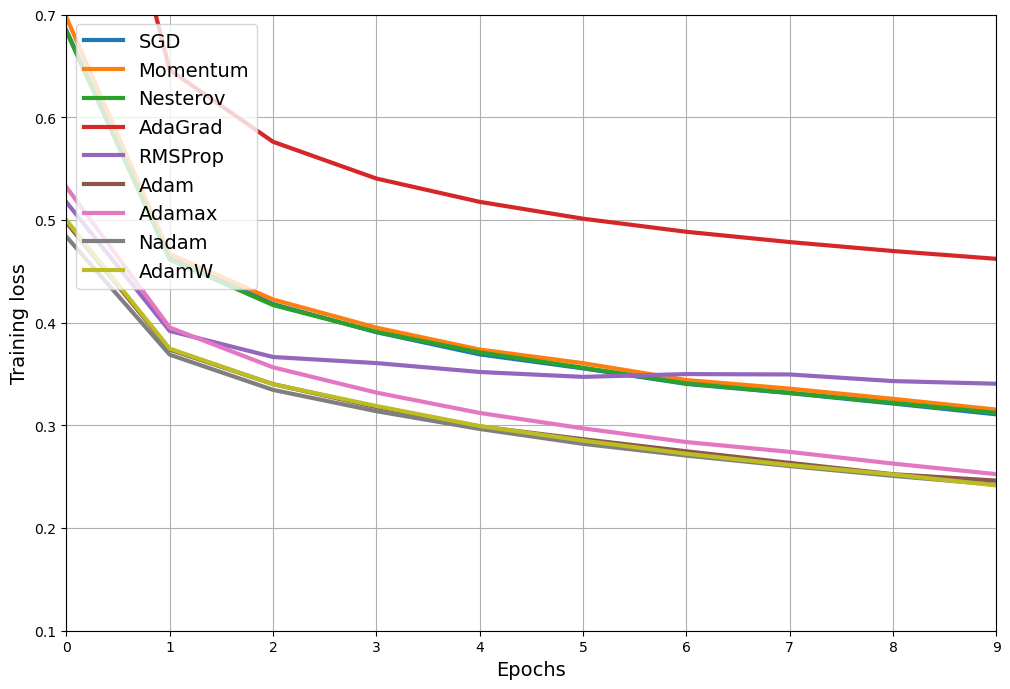

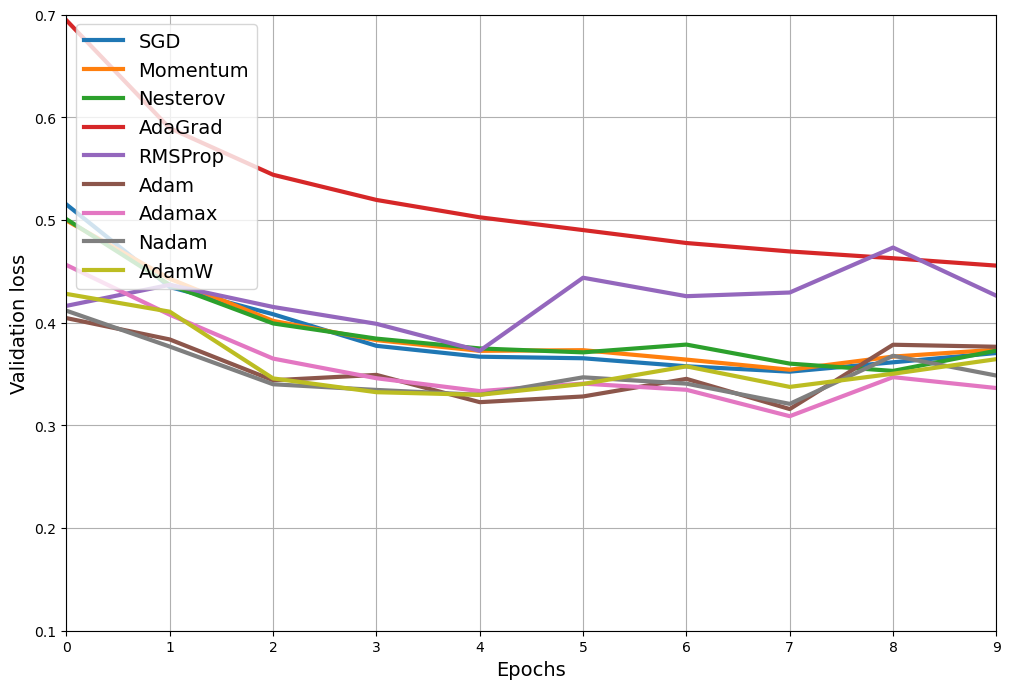

In [64]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```learning_rate = initial_learning_rate / (1 + step / decay_steps)**power```

Keras uses ```power = 1```.



**Note**: Optimizers used to have a ```decay``` argument for this, but it was deprecated. You must use the schedulers in ```tf.keras.optimizers.schedules``` instead.

In [65]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

The ```InverseTimeDecay``` scheduler uses ```learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)```. If you set ```staircase=True```, then it replaces ```step / decay_step``` with ```floor(step / decay_step)```.

In [66]:

history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 779us/step - loss: 0.6912 - accuracy: 0.7639 - val_loss: 0.4904 - val_accuracy: 0.8256
Epoch 2/10
1719/1719 [==============================] - 1s 737us/step - loss: 0.4758 - accuracy: 0.8331 - val_loss: 0.4550 - val_accuracy: 0.8348
Epoch 3/10
1719/1719 [==============================] - 1s 737us/step - loss: 0.4277 - accuracy: 0.8493 - val_loss: 0.4112 - val_accuracy: 0.8518
Epoch 4/10
1719/1719 [==============================] - 1s 736us/step - loss: 0.4028 - accuracy: 0.8571 - val_loss: 0.3861 - val_accuracy: 0.8576
Epoch 5/10
1719/1719 [==============================] - 1s 736us/step - loss: 0.3842 - accuracy: 0.8634 - val_loss: 0.3849 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 1s 741us/step - loss: 0.3701 - accuracy: 0.8681 - val_loss: 0.3841 - val_accuracy: 0.8636
Epoch 7/10
1719/1719 [==============================] - 1s 737us/step - loss: 0.3600 - accuracy: 0.8702 - val_loss: 0.3727 -

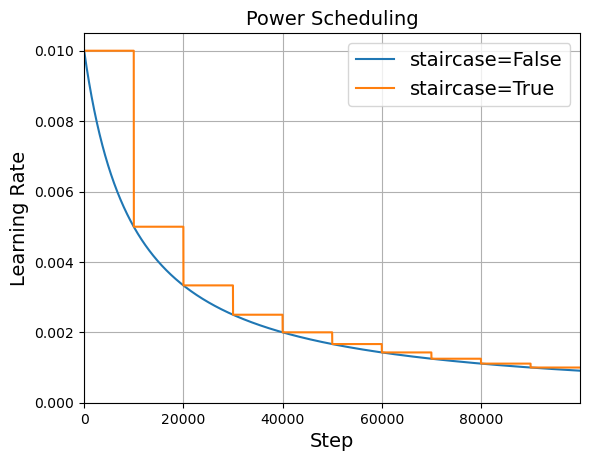

In [67]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Exponential Scheduling
```learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)```

In [68]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [69]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 778us/step - loss: 0.7150 - accuracy: 0.7533 - val_loss: 0.5159 - val_accuracy: 0.8208
Epoch 2/10
1719/1719 [==============================] - 1s 738us/step - loss: 0.4805 - accuracy: 0.8310 - val_loss: 0.4479 - val_accuracy: 0.8386
Epoch 3/10
1719/1719 [==============================] - 1s 727us/step - loss: 0.4323 - accuracy: 0.8473 - val_loss: 0.4214 - val_accuracy: 0.8516
Epoch 4/10
1719/1719 [==============================] - 1s 725us/step - loss: 0.4096 - accuracy: 0.8559 - val_loss: 0.3980 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 1s 731us/step - loss: 0.3918 - accuracy: 0.8613 - val_loss: 0.3877 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 1s 729us/step - loss: 0.3793 - accuracy: 0.8661 - val_loss: 0.3922 - val_accuracy: 0.8596
Epoch 7/10
1719/1719 [==============================] - 1s 729us/step - loss: 0.3706 - accuracy: 0.8691 - val_loss: 0.3765 -

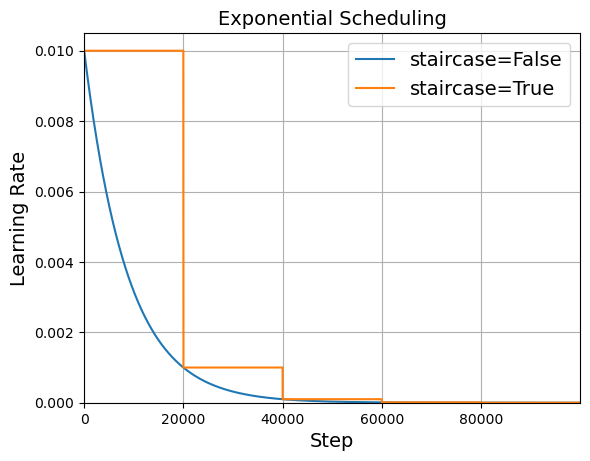

In [70]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a ```LearningRateScheduler``` callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [71]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [72]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [73]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [74]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 2s 926us/step - loss: 0.6754 - accuracy: 0.7685 - val_loss: 0.4762 - val_accuracy: 0.8328 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 1s 732us/step - loss: 0.4664 - accuracy: 0.8360 - val_loss: 0.4620 - val_accuracy: 0.8290 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 1s 731us/step - loss: 0.4193 - accuracy: 0.8512 - val_loss: 0.4120 - val_accuracy: 0.8514 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 1s 728us/step - loss: 0.3950 - accuracy: 0.8602 - val_loss: 0.3858 - val_accuracy: 0.8634 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 1s 729us/step - loss: 0.3755 - accuracy: 0.8673 - val_loss: 0.3831 - val_accuracy: 0.8580 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 1s 735us/step - loss: 0.3604 - accuracy: 0.8714 - val_loss: 0.3917 - val_accuracy: 0.8576 - lr: 0.0056
Epoch 7/20
1719/1719 [========================

Alternatively, the schedule function can take the current learning rate as a second argument:

In [75]:

def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [76]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = self.model.optimizer.learning_rate.numpy()
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        self.model.optimizer.learning_rate = new_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

In [77]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [78]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 [==============================] - 2s 948us/step - loss: 0.6951 - accuracy: 0.7622 - val_loss: 0.4940 - val_accuracy: 0.8272 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 2s 938us/step - loss: 0.4770 - accuracy: 0.8330 - val_loss: 0.4730 - val_accuracy: 0.8300 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 2s 928us/step - loss: 0.4315 - accuracy: 0.8474 - val_loss: 0.4249 - val_accuracy: 0.8508 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 2s 911us/step - loss: 0.4066 - accuracy: 0.8570 - val_loss: 0.3965 - val_accuracy: 0.8562 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 2s 899us/step - loss: 0.3867 - accuracy: 0.8636 - val_loss: 0.3817 - val_accuracy: 0.8608 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 2s 875us/step - loss: 0.3712 - accuracy: 0.8676 - val_loss: 0.3879 - val_accuracy: 0.8612 - lr: 0.0050
Epoch 7/20
1719/1719 [========================

## Piecewise Constant Scheduling

In [79]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [80]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 789us/step - loss: 0.6703 - accuracy: 0.7705 - val_loss: 0.4762 - val_accuracy: 0.8314
Epoch 2/10
1719/1719 [==============================] - 1s 727us/step - loss: 0.4661 - accuracy: 0.8360 - val_loss: 0.4434 - val_accuracy: 0.8342
Epoch 3/10
1719/1719 [==============================] - 1s 708us/step - loss: 0.4197 - accuracy: 0.8513 - val_loss: 0.4090 - val_accuracy: 0.8568
Epoch 4/10
1719/1719 [==============================] - 1s 711us/step - loss: 0.3951 - accuracy: 0.8603 - val_loss: 0.3819 - val_accuracy: 0.8646
Epoch 5/10
1719/1719 [==============================] - 1s 711us/step - loss: 0.3738 - accuracy: 0.8677 - val_loss: 0.3754 - val_accuracy: 0.8662
Epoch 6/10
1719/1719 [==============================] - 1s 713us/step - loss: 0.3570 - accuracy: 0.8727 - val_loss: 0.3774 - val_accuracy: 0.8692
Epoch 7/10
1719/1719 [==============================] - 1s 709us/step - loss: 0.3450 - accuracy: 0.8766 - val_loss: 0.3593 -

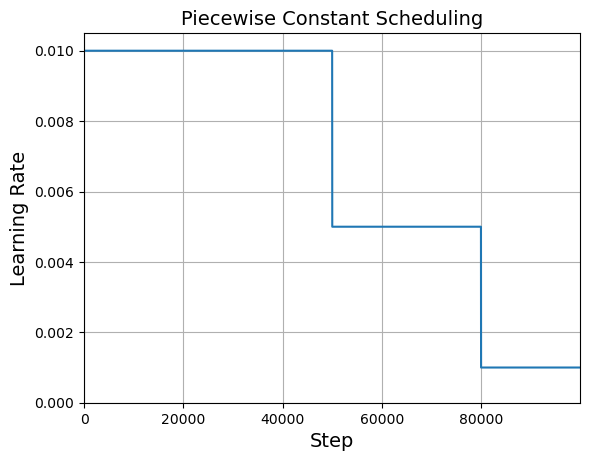

In [81]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [82]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [83]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [84]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 887us/step - loss: 0.5418 - accuracy: 0.8106 - val_loss: 0.4501 - val_accuracy: 0.8474 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 1s 852us/step - loss: 0.4475 - accuracy: 0.8405 - val_loss: 0.4554 - val_accuracy: 0.8392 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 1s 855us/step - loss: 0.4206 - accuracy: 0.8520 - val_loss: 0.4335 - val_accuracy: 0.8490 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 1s 837us/step - loss: 0.4157 - accuracy: 0.8538 - val_loss: 0.4117 - val_accuracy: 0.8560 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 892us/step - loss: 0.4016 - accuracy: 0.8600 - val_loss: 0.4044 - val_accuracy: 0.8544 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 904us/step - loss: 0.3524 - accuracy: 0.8732 - val_loss: 0.3767 - val_accuracy: 0.8658 - lr: 0.0050
Epoch 7/25
1719/1719 [========================

We've looked at ```InverseTimeDecay```, ```ExponentialDecay```, and ```PiecewiseConstantDecay```. A few more schedulers are available in ```tf.keras.optimizers.schedules```, here is the full list:

In [85]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

In [86]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [87]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])


Epoch 1/25
1719/1719 [==============================] - 2s 802us/step - loss: 0.7013 - accuracy: 0.7613 - val_loss: 0.4868 - val_accuracy: 0.8312 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 1s 731us/step - loss: 0.4693 - accuracy: 0.8364 - val_loss: 0.4480 - val_accuracy: 0.8382 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 1s 728us/step - loss: 0.4222 - accuracy: 0.8504 - val_loss: 0.4136 - val_accuracy: 0.8566 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 1s 729us/step - loss: 0.3961 - accuracy: 0.8598 - val_loss: 0.3871 - val_accuracy: 0.8662 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 1s 734us/step - loss: 0.3749 - accuracy: 0.8672 - val_loss: 0.3767 - val_accuracy: 0.8642 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 1s 730us/step - loss: 0.3581 - accuracy: 0.8729 - val_loss: 0.3787 - val_accuracy: 0.8664 - lr: 0.0100
Epoch 7/25
1719/1719 [========================

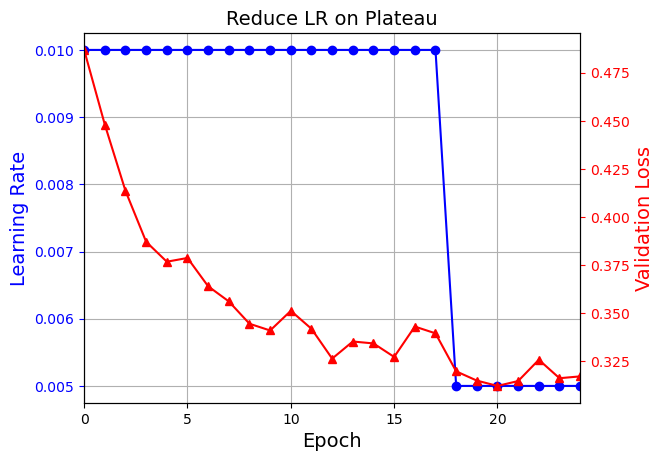

In [91]:
# extra code – this cell plots performance scheduling

# had to change history.history["learning_rate"] to history.history["lr"] to get it to work
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## 1Cycle scheduling
The ```ExponentialLearningRate``` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant factor. It also saves the learning rate and loss at each batch. Since ```logs["loss"]``` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [92]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

The ```find_learning_rate()``` function trains the model using the ```ExponentialLearningRate``` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [93]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The ```plot_lr_vs_loss()``` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [94]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [95]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 1ms/step - loss: 1.8168 - accuracy: 0.3531


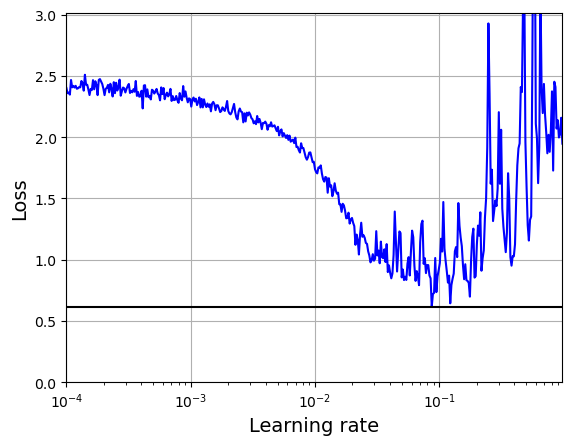

In [96]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around $10^{–1}$.

The ```OneCycleScheduler``` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [97]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

Let's build and compile a simple Fashion MNIST model, then train it using the ```OneCycleScheduler``` callback:

In [98]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 1ms/step - loss: 0.9804 - accuracy: 0.6875 - val_loss: 0.6362 - val_accuracy: 0.7836
Epoch 2/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5844 - accuracy: 0.7959 - val_loss: 0.4983 - val_accuracy: 0.8274
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5051 - accuracy: 0.8229 - val_loss: 0.4552 - val_accuracy: 0.8404
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4595 - accuracy: 0.8373 - val_loss: 0.4407 - val_accuracy: 0.8452
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4290 - accuracy: 0.8463 - val_loss: 0.4441 - val_accuracy: 0.8372
Epoch 6/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4016 - accuracy: 0.8566 - val_loss: 0.5732 - val_accuracy: 0.7914
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3867 - accuracy: 0.8603 - val_loss: 0.3968 - val_accuracy: 0.8530
Epoch 

## Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [99]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use ```l1(0.1)``` for $\ell_1$ regularization with a factor of 0.1, or ```l1_l2(0.1, 0.01)``` for both $\ell_1$ and $\ell_2$ regularization, with factors 0.1 and 0.01 respectively.

In [100]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [101]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [102]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 791us/step - loss: 3.1455 - accuracy: 0.7744 - val_loss: 1.8735 - val_accuracy: 0.8242
Epoch 2/2
1719/1719 [==============================] - 1s 703us/step - loss: 1.4322 - accuracy: 0.8151 - val_loss: 1.1315 - val_accuracy: 0.8168



## Dropout

In [103]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [105]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6732 - accuracy: 0.7505 - val_loss: 0.4565 - val_accuracy: 0.8332
Epoch 2/10
1719/1719 [==============================] - 2s 968us/step - loss: 0.5132 - accuracy: 0.8126 - val_loss: 0.4080 - val_accuracy: 0.8476
Epoch 3/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.4717 - accuracy: 0.8277 - val_loss: 0.3830 - val_accuracy: 0.8578
Epoch 4/10
1719/1719 [==============================] - 2s 967us/step - loss: 0.4474 - accuracy: 0.8363 - val_loss: 0.3830 - val_accuracy: 0.8552
Epoch 5/10
1719/1719 [==============================] - 2s 967us/step - loss: 0.4340 - accuracy: 0.8391 - val_loss: 0.3637 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 2s 981us/step - loss: 0.4265 - accuracy: 0.8421 - val_loss: 0.3652 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 2s 963us/step - loss: 0.4144 - accuracy: 0.8486 - val_loss: 0.3584 - v

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [106]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 1s 537us/step - loss: 0.3094 - accuracy: 0.8853


[0.3094475567340851, 0.885272741317749]

In [107]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 538us/step - loss: 0.3613 - accuracy: 0.8689


[0.36132925748825073, 0.8689000010490417]

**Note**: make sure to use ```AlphaDropout``` instead of ```Dropout``` if you want to build a self-normalizing neural net using SELU.

### MC Dropout

In [108]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [109]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [110]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 59ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.023, 0.   , 0.228, 0.   ,
        0.748]], dtype=float32)

In [111]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.051, 0.   , 0.231, 0.002,
       0.715], dtype=float32)

In [113]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.002, 0.001, 0.001, 0.001, 0.001, 0.064, 0.003, 0.154, 0.004,
       0.177], dtype=float32)

In [114]:

y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8684

In [115]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [116]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [117]:
mc_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_89 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_90 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_91 (Dense)            (None, 10)              


Now we can use the model with MC Dropout:

In [118]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 10ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.27, 0.01, 0.64]],
      dtype=float32)

### Max norm

In [119]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [120]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 775us/step - loss: 0.5501 - accuracy: 0.8044 - val_loss: 0.4378 - val_accuracy: 0.8332
Epoch 2/10
1719/1719 [==============================] - 1s 733us/step - loss: 0.4102 - accuracy: 0.8499 - val_loss: 0.4183 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 1s 728us/step - loss: 0.3775 - accuracy: 0.8601 - val_loss: 0.3627 - val_accuracy: 0.8684
Epoch 4/10
1719/1719 [==============================] - 1s 727us/step - loss: 0.3580 - accuracy: 0.8690 - val_loss: 0.3431 - val_accuracy: 0.8714
Epoch 5/10
1719/1719 [==============================] - 1s 729us/step - loss: 0.3439 - accuracy: 0.8727 - val_loss: 0.3520 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 1s 726us/step - loss: 0.3358 - accuracy: 0.8756 - val_loss: 0.4002 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 1s 730us/step - loss: 0.3283 - accuracy: 0.8783 - val_loss: 0.3666 -

## Exercises

### 1. to 7. 

1. What is the problem that Glorot and He initializations aim to fix?

Greg answer: exploding gradients

Book answer: Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.

2. Is it ok to initialize the weights to have all the same value as long as that value was selected using He initialization?

Greg answer: No, need random sampling for good weight initialization.

Book answer: No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.

3. Is it ok to initialize the bias term to 0?

Greg: Yes

Book: It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.

4. In which cases would you want to use each of the activation functions we discussed in this chapter?

ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.

5. What may happen if you set the momentum hyperparameter too close to 1 when using an SGD optimizer?

Greg answer: It will overshoot the optimum and take a long time to converge to a good solution as a result.

Book answer: If you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.

6. Name three ways you can produce a sparse model

Greg: dropout, using sparse layers, and uhh?

Book: One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ1 regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.

7. Does dropout slow down training? Does it slow down inference (i.e. making predictions on new instances)? What about MC dropout?

Greg: No yes no

Book: Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

8. 

a.  Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.



In [121]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

b. Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with tf.keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.

Let's add the output layer to the model:

In [122]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [123]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [124]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 15s 0us/step


Now we can create the callbacks we need and train the model:

In [125]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [126]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [127]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 7s 3ms/step - loss: 5.4688 - accuracy: 0.1614 - val_loss: 2.1376 - val_accuracy: 0.2102
Epoch 2/100
1407/1407 [==============================] - 4s 3ms/step - loss: 2.0678 - accuracy: 0.2360 - val_loss: 2.0120 - val_accuracy: 0.2628
Epoch 3/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.9574 - accuracy: 0.2815 - val_loss: 1.9146 - val_accuracy: 0.2938
Epoch 4/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8823 - accuracy: 0.3144 - val_loss: 1.8989 - val_accuracy: 0.3164
Epoch 5/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.8249 - accuracy: 0.3371 - val_loss: 1.7718 - val_accuracy: 0.3498
Epoch 6/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7786 - accuracy: 0.3554 - val_loss: 1.7310 - val_accuracy: 0.3700
Epoch 7/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7335 - accuracy: 0.3706 - val_loss: 1.7063 - val_ac

In [128]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5203 - accuracy: 0.4608


[1.520341396331787, 0.4607999920845032]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.